In [1]:
import pandas as pd

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import geojson

import folium
from folium.plugins import HeatMap
import branca.colormap as cm

import plotly.express as px

import numpy as np

In [2]:
df_b = pd.read_parquet("./data/business.parquet")

In [3]:
df = gpd.GeoDataFrame(
    df_b,
    geometry=gpd.points_from_xy(df_b.longitude, df_b.latitude),
    crs="EPSG:4326" 
)

In [4]:
m = folium.Map(location=[27.9011955,-82.5318599], zoom_start=10, tiles="cartodb positron")

def get_color(stars) -> str:
    if stars > 4:
        return "green"
    elif stars > 3:
        return "lightgreen"
    elif stars > 2:
        return "orange"
    elif stars > 1:
        return "red"
    return "purple"

for idx, row in df_b.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        tooltip=row["name"],
        popup=folium.Popup(
            f"<b>{row['name']}</b><br>"
            f"Rating: {row['stars']} ⭐<br>",
            max_width=300
        ),
        icon=folium.Icon(color=get_color(row["stars"]), prefix="fa", icon="dumbbell")
    ).add_to(m)


m

In [5]:
m = folium.Map(location=[27.9011955,-82.5318599], zoom_start=11, tiles="cartodb positron")
data = df[["latitude", "longitude"]].values.tolist() 


HeatMap(data).add_to(m)

m

In [6]:
m = folium.Map(location=[27.9011955, -82.5318599], zoom_start=10, tiles="cartodb positron")

colormap = cm.linear.YlOrRd_09.scale(df_b["review_count"].min(), df_b["review_count"].max())
colormap.caption = "Number of Reviews"

for _, row in df_b.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=max(3, row["review_count"] ** 0.7),
        color=colormap(row["review_count"]),
        fill=True,
        fill_color=colormap(row["review_count"]),
        fill_opacity=0.6,
        tooltip=row["name"],
        popup=folium.Popup(
            f"<b>{row['name']}</b><br>"
            f"Reviews: {row['review_count']}<br>",
            max_width=300
        )
    ).add_to(m)

colormap.add_to(m)

m

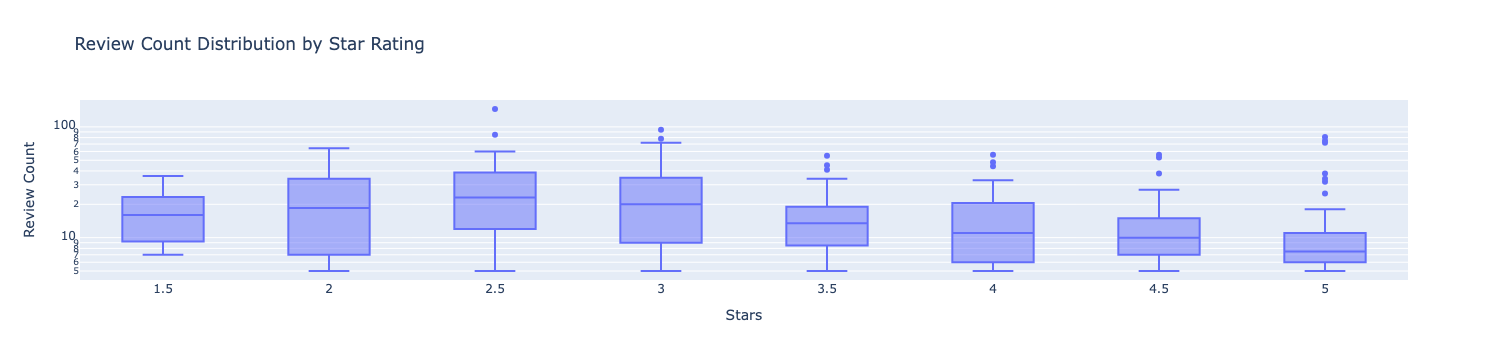

In [7]:
fig = px.box(
    df_b,
    x="stars",
    y="review_count",
    points=None,
    log_y=True,
    labels={"stars": "Stars", "review_count": "Review Count"},
    title="Review Count Distribution by Star Rating"
)
fig.show()

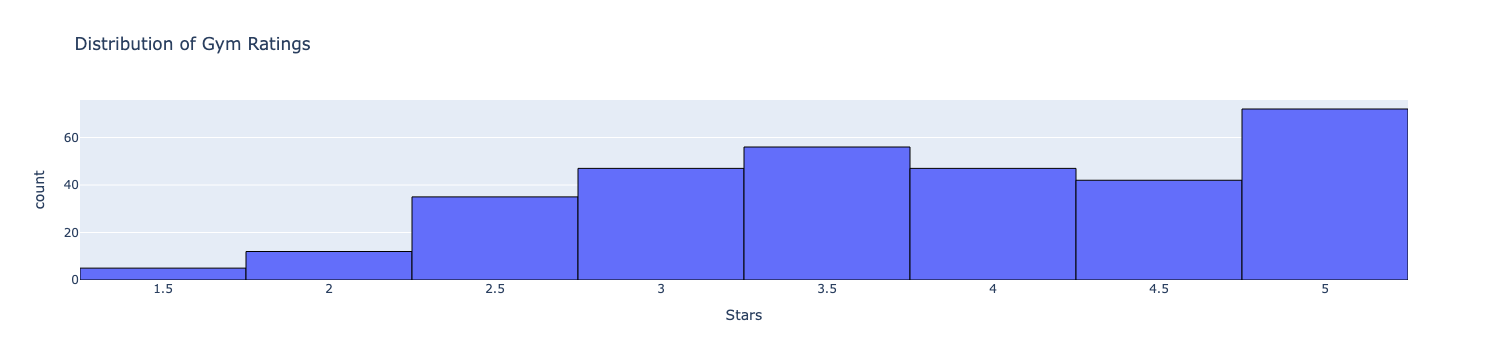

In [8]:
fig = px.histogram(
    df_b,
    x="stars",
    nbins=10,
    labels={"stars": "Stars"},
    title="Distribution of Gym Ratings"
)
fig.update_traces(marker=dict(line=dict(width=1, color="black")))
fig.show()


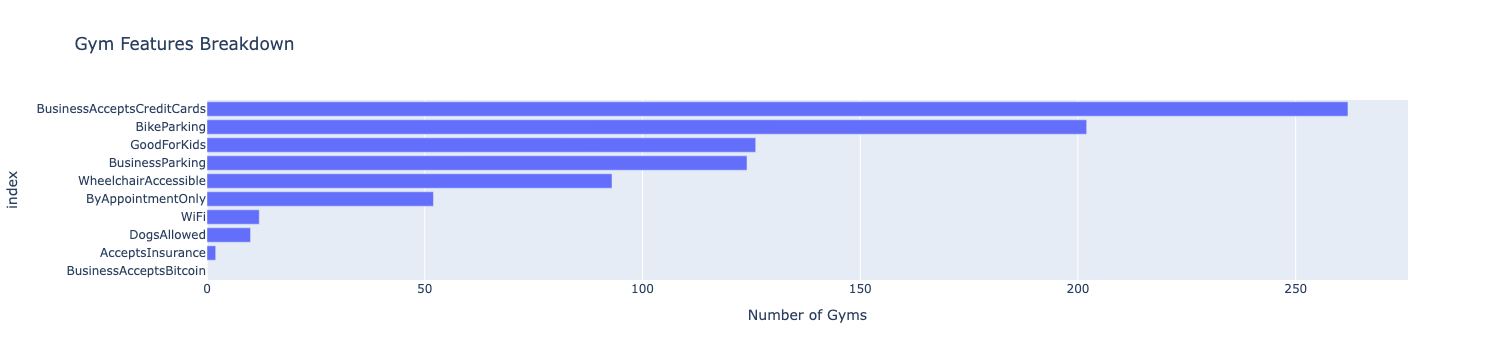

In [9]:
features_expanded = df_b["features"].dropna().apply(pd.Series)
feature_counts = features_expanded.sum().sort_values(ascending=True)

fig = px.bar(
    feature_counts,
    x=feature_counts.values,
    y=feature_counts.index,
    orientation="h",
    labels={"x": "Number of Gyms", "y": "Feature"},
    title="Gym Features Breakdown"
)
fig.show()


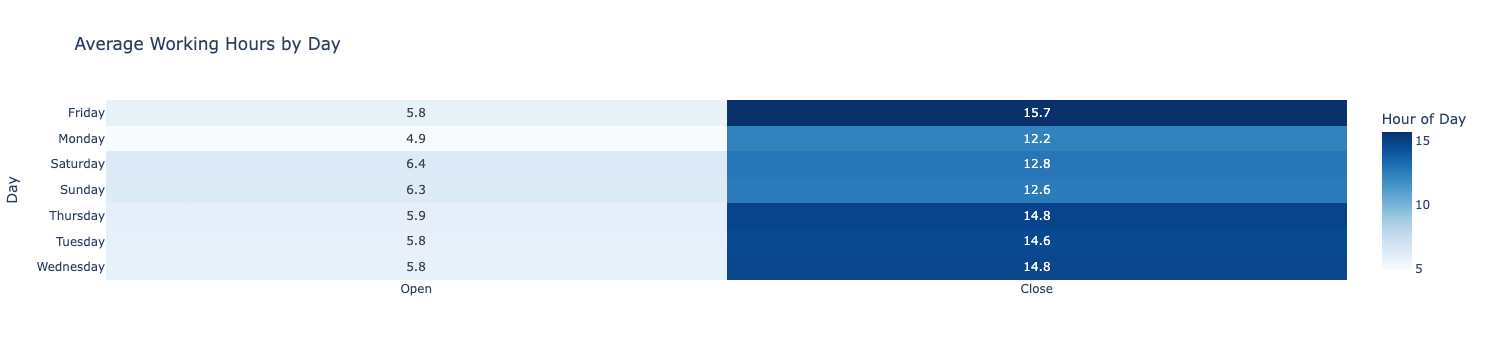

In [10]:
working_expanded = (
    df_b["working_days"]
    .dropna()
    .apply(pd.Series)
    .melt(var_name="Day", value_name="Hours")
    .dropna()
)

working_expanded[["Open", "Close"]] = working_expanded["Hours"].apply(
    lambda x: pd.Series([x[0].hour, x[1].hour])
)

avg_hours = working_expanded.groupby("Day")[["Open", "Close"]].mean().reset_index()

fig = px.imshow(
    avg_hours.set_index("Day"),
    text_auto=".1f",
    aspect="auto",
    color_continuous_scale="Blues",
    labels=dict(color="Hour of Day"),
    title="Average Working Hours by Day"
)
fig.show()


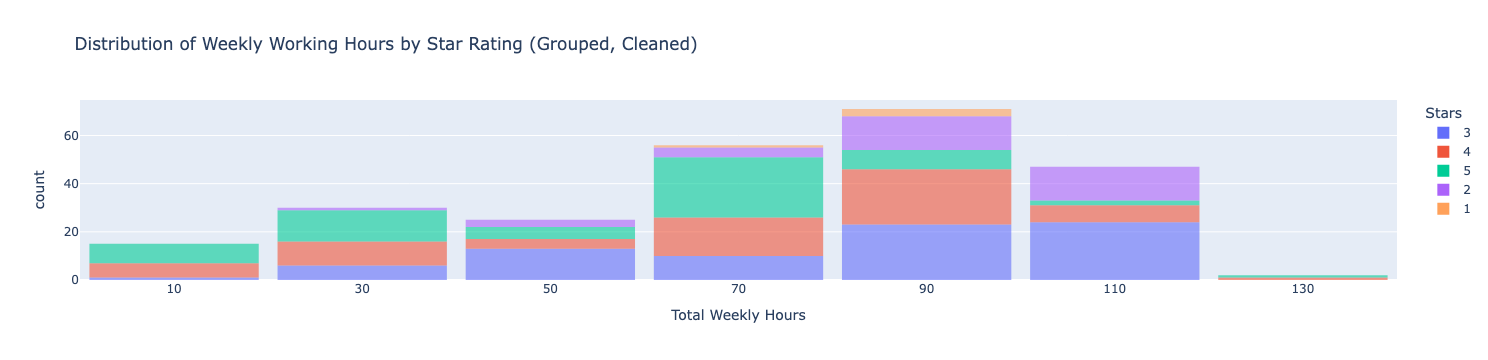

In [11]:
working_expanded = (
    df_b[["business_id", "stars", "working_days"]]
    .dropna(subset=["working_days"])
    .set_index("business_id")["working_days"]
    .apply(pd.Series)
    .melt(ignore_index=False, var_name="Day", value_name="Hours")
    .dropna()
    .reset_index()
)

working_expanded["Duration"] = working_expanded["Hours"].apply(
    lambda x: (x[1].hour + x[1].minute/60) - (x[0].hour + x[0].minute/60)
)

working_expanded.loc[working_expanded["Duration"] < 0, "Duration"] += 24

weekly_hours = working_expanded.groupby("business_id")["Duration"].sum().reset_index()
weekly_hours = weekly_hours.merge(df_b[["business_id", "stars"]], on="business_id")

weekly_hours["stars_grouped"] = np.floor(weekly_hours["stars"]).astype(int)

weekly_hours_clean = weekly_hours[weekly_hours["Duration"] > 0].copy()

fig = px.histogram(
    weekly_hours_clean,
    x="Duration",
    color="stars_grouped",
    nbins=10,
    barmode="relative",
    opacity=0.6,
    labels={"Duration": "Total Weekly Hours", "stars_grouped": "Stars"},
    title="Distribution of Weekly Working Hours by Star Rating (Grouped, Cleaned)"
)

fig.update_layout(bargap=0.1)
fig.show()